In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy import interp
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import os

#Loading data
books = pd.read_csv(os.path.join("book-recommend-data", "Books.csv"), sep=',', header=0, encoding="latin1")
users = pd.read_csv(os.path.join("book-recommend-data", "Users.csv"), sep=',', header=0, encoding="latin1")
user_events = pd.read_csv(os.path.join("book-recommend-data", "UserEvents.csv"), sep=',', header=0, encoding="latin1")

In [2]:
#Setting random seeds
seed = 0
np.random.seed(seed)

In [3]:
#Looking at the User's data
users.head()

,Unnamed: 0,Unnamed: 0.1,user,location,age
0,57300,43156,43157.0,"windsor, ontario, canada",22.0
1,40638,99031,99032.0,"white plains, new york, usa",25.0
2,54265,42882,42883.0,"the woodlands, texas, usa",51.0
3,83797,183799,183800.0,"quebec, quebec, canada",29.0
4,96743,188795,188796.0,"toronto, ontario, canada",NaN


In [4]:
#Looking at the Book's data
books.head()

,Unnamed: 0,Unnamed: 0.1,bookISBN,bookName,author,yearOfPublication,publisher,urlId
0,62044,26575,1551669382,Enchanted Afternoon,Susan Wiggs,2002,Mira,120656.0
1,85751,1995,0743202961,Every Breath You Take : A True Story of Obsess...,Ann Rule,2001,Free Press,116803.0
2,122688,7677,067151699X,The HIDDEN LIFE OF DOGS,Elizabeth Marshall Thomas,1995,Pocket,1805.0
3,87360,36120,0804108528,Inadmissible Evidence,Philip Friedman,1993,Ivy Books,139375.0
4,73712,30238,0061094145,"The Fifth Dominion (Imajica, Book 1)",Clive Barker,1995,HarperTorch,141585.0


In [5]:
#Looking at the User event's data
user_events.head()

,Unnamed: 0,user,bookId,impression
0,16,276747,0060517794,checkout
1,19,276747,0671537458,checkout
2,20,276747,0679776818,add to cart
3,133,276822,0060096195,checkout
4,137,276822,0375821813,checkout


In [6]:
#Check for NaN and the type of the columns in the resulting DataFrames
print('Books')
for column in books.columns:
    print('Column', column, 
          'has nan', books[column].isnull().values.any(),
          '| type', books[column].dtype)
print('---------------')
print('Users')
for column in users.columns:
    print('Column', column, 
          'has nan', users[column].isnull().values.any(),
          '| type', users[column].dtype)
print('---------------')
print('User events')
for column in user_events.columns:
    print('Column', column, 
          'has nan', user_events[column].isnull().values.any(),
          '| type', user_events[column].dtype)

Books
Column Unnamed: 0 has nan False | type int64
Column Unnamed: 0.1 has nan False | type int64
Column bookISBN has nan False | type object
Column bookName has nan False | type object
Column author has nan True | type object
Column yearOfPublication has nan False | type int64
Column publisher has nan False | type object
Column urlId has nan True | type float64
---------------
Users
Column Unnamed: 0 has nan False | type int64
Column Unnamed: 0.1 has nan False | type int64
Column user has nan False | type float64
Column location has nan True | type object
Column age has nan True | type float64
---------------
User events
Column Unnamed: 0 has nan False | type int64
Column user has nan False | type int64
Column bookId has nan False | type object
Column impression has nan False | type object


In [7]:
#It seens that the user field in the User's dataframe was interpreted as a float value.
#The location field can also have some Null values. The same can happen to the field age
#Here a field age_defined will be created to indicate that the age is not defined for an user

users['user'] = users['user'].apply(lambda x: str(x).split('.')[0])
users['location'].fillna('', inplace=True)
users['location'] = users['location'].apply(lambda x: x.replace(',', ''))
users['age'] = users['age'].astype(float)
users['age'].fillna(0.0, inplace=True)
users['age_defined'] = ~(users['age'] == 0.0)
users.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [8]:
#Looking at the result
users.head()

,user,location,age,age_defined
0,43157,windsor ontario canada,22.0,True
1,99032,white plains new york usa,25.0,True
2,42883,the woodlands texas usa,51.0,True
3,183800,quebec quebec canada,29.0,True
4,188796,toronto ontario canada,0.0,False


In [9]:
#Removing unused fields from the Book's dataframe
books['author'].fillna('', inplace=True)
books.drop(['urlId', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True) #We are not using the urlid field

In [10]:
#Looking at the result
books.head()

,bookISBN,bookName,author,yearOfPublication,publisher
0,1551669382,Enchanted Afternoon,Susan Wiggs,2002,Mira
1,0743202961,Every Breath You Take : A True Story of Obsess...,Ann Rule,2001,Free Press
2,067151699X,The HIDDEN LIFE OF DOGS,Elizabeth Marshall Thomas,1995,Pocket
3,0804108528,Inadmissible Evidence,Philip Friedman,1993,Ivy Books
4,0061094145,"The Fifth Dominion (Imajica, Book 1)",Clive Barker,1995,HarperTorch


In [11]:
#The field Unnamed: 0 is assumed to be larger for interactions that happened later
#We need this field so we can select interactions that happened before a checkout. So we will rename this field to
#order
#We will also assert that the user field is a string
user_events.rename(index=str, columns={'Unnamed: 0': 'order'}, inplace=True)
user_events['user'] = user_events['user'].astype(str)

In [12]:
#Looking at the result
user_events.head()

,order,user,bookId,impression
0,16,276747,0060517794,checkout
1,19,276747,0671537458,checkout
2,20,276747,0679776818,add to cart
3,133,276822,0060096195,checkout
4,137,276822,0375821813,checkout


In [13]:
#Checking column behavior
print('Different impressions', user_events['impression'].unique())

print('Min book year', books['yearOfPublication'].min())
print('Max book year', books['yearOfPublication'].max())

print('Min age user', users['age'].min())
print('Max age user', users['age'].max())

Different impressions ['checkout' 'add to cart' 'view' 'like' 'interact' 'dislike']
Min book year 0
Max book year 2005
Min age user 0.0
Max age user 209.0


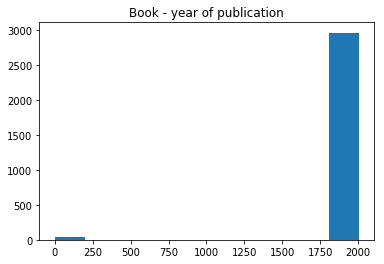

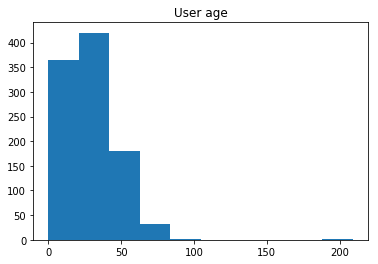

In [14]:
#It seens that we have some outliers on the book's year field and on the user's age field. 
#Let's check if they are significant

plt.figure()
plt.title('Book - year of publication')
rbins = plt.hist(books['yearOfPublication'])

plt.figure()
plt.title('User age')
rbins = plt.hist(users['age'])

In [15]:
#The outliers are not very frequent, so i will not do anything for now

In [16]:
#Let's check how we can link the datasets
set_u_user = set(users['user'])
set_ue_user = set(user_events['user'])
set_b_bookid = set(books['bookISBN'])
set_ue_bookid = set(user_events['bookId'])

p_user = 100.0*len(set_u_user.intersection(set_ue_user))/float(len(set_u_user))
p_bookid = 100.0*len(set_b_bookid.intersection(set_ue_bookid))/float(len(set_b_bookid))

print('Num users in the Users dataframe', len(set_u_user))
print('Num users in the User events dataframe', len(set_ue_user))
print('Percentage of user ids in the user event %2.2f %%' % p_user)

print('Num books in the Books dataframe', len(set_b_bookid))
print('Num books in the User events dataframe', len(set_ue_bookid))
print('Percentage of book ids in the user event %2.2f %%' % p_user)

Num users in the Users dataframe 1000
Num users in the User events dataframe 13030
Percentage of user ids in the user event 100.00 %
Num books in the Books dataframe 3000
Num books in the User events dataframe 11234
Percentage of book ids in the user event 100.00 %


In [17]:
#We can see that the User's dataframe and the User event's dataframe can be linked by the user field, but there are
#Events which have user's that aren't on the User's dataframe. The same happens with the Book dataframe 
#and the bookISBN field, which can be linked with the bookId field

In [18]:
def get_valid_books(user_events_df, books_df, valid_users):
    set_usable_book_ids = set(user_events_df[(user_events_df['impression'] == 'checkout') & 
                                         (user_events_df['user'].isin(valid_users))]['bookId'])
    set_known_book_ids = set(books_df['bookISBN'])
    set_books_valid_users = list(set_usable_book_ids.intersection(set_known_book_ids))
    return set_books_valid_users

def get_num_purchases_by_book(user_events_df, valid_users, valid_books):
    print('Verifying how many times each book was bought')
    num_sales = {}
    filtered_events_df = user_events_df[(user_events_df['impression'] == 'checkout') 
                                      & (user_events_df['user'].isin(valid_users))]
    for book in tqdm(valid_books):
        relevant_events = filtered_events_df[filtered_events_df['bookId'] == book]
        current_num_sales = relevant_events.shape[0]
        num_sales[book] = current_num_sales
    return num_sales

In [19]:
#Let's check for book significance. That is, the books that were bought by someone (impression = checkout) who is a 
#known user
set_valid_users = set(users['user'])
set_books_valid_users = get_valid_books(user_events, books, set_valid_users)
print('Number of different known books that were bought by a known user', len(set_books_valid_users))

Number of different known books that were bought by a known user 810


In [20]:
#We can see that only 810 from the 3000 books where bought by a valid user

In [21]:
#Let's check how many times each book was bought
num_sales = get_num_purchases_by_book(user_events, set_valid_users, set_books_valid_users)

Verifying how many times each book was bought


100%|██████████| 810/810 [00:01<00:00, 675.95it/s]


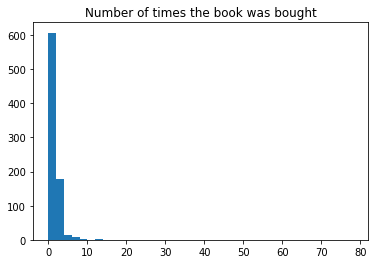

In [22]:
plt.figure()
plt.title('Number of times the book was bought')
rbins = plt.hist(num_sales.values(), bins=[x for x in range(0,80, 2)])

In [23]:
#We can see that the numbers are really small. Let's remove the imposition that the user should be known

In [24]:
set_all_users = set(user_events['user'])
set_books = get_valid_books(user_events, books, set_all_users)
print('Number of different known books that were bought by a known or unknown user', len(set_books))

Number of different known books that were bought by a known or unknown user 2772


In [25]:
#Verifying book relevance
num_sales = get_num_purchases_by_book(user_events, set_all_users, set_books)

Verifying how many times each book was bought


100%|██████████| 2772/2772 [00:36<00:00, 76.83it/s]


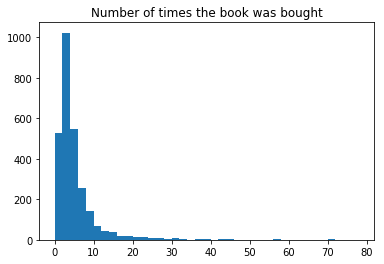

In [26]:
plt.figure()
plt.title('Number of times the book was bought')
rbins = plt.hist(num_sales.values(), bins=[x for x in range(0,80, 2)])

In [27]:
#For now, let's limitate our analysis to the books which were bought at least 10 times. We will also not limitate the 
#users to the ones present at the User's dataframe
minimum_number_of_sales = 10
set_valid_books = list([k for k in num_sales.keys() if num_sales[k] >= minimum_number_of_sales])
print('Number of valid books', len(set_valid_books))

Number of valid books 281


In [28]:
def create_book_info_dictionary(book_dataframe):
    book_dict = {}
    for _, row in book_dataframe.iterrows():
        book_dict[row['bookISBN']] = {'author': row['author'], 
                                      'name': row['bookName'], 
                                      'year': row['yearOfPublication'],
                                      'publisher': row['publisher']
                                     }
    return book_dict

def create_user_info_dictionary(user_dataframe):
    user_dict = {}
    for _, row in user_dataframe.iterrows():
        user_dict[row['user']] = {'age': row['age'], 
                                  'location': row['location'], 
                                  'age_defined': int(row['age_defined'])}
    return user_dict

def append_number_in_dictionary(my_dict, my_key, value, avoid_zeros=True):
    if value == 0 and avoid_zeros:
        return 
    
    if my_key in my_dict:
        my_dict[my_key].append(float(value))
    else:
        my_dict[my_key] = [float(value)]

def append_string_in_dictionary(my_dict, my_key, value):
    if my_key in my_dict:
        my_dict[my_key] += ' ' + str(value)
    else:
        my_dict[my_key] = str(value)

def build_prototype_dict(existent_impressions):
    prototype_dict = {}
    
    for impr in existent_impressions:
        impr_id = impr + '_id'
        impr_name = impr + '_name'
        impr_author = impr + '_author'
        impr_year = impr + '_year'
        impr_publisher = impr + '_publisher'
        
        prototype_dict[impr_id] = ''
        prototype_dict[impr_name] = ''
        prototype_dict[impr_author] = ''
        prototype_dict[impr_year] = []
        prototype_dict[impr_publisher] = ''
    
    prototype_dict.update({'age': 0.0, 'location': '', 'age_defined': 0})
    return prototype_dict

def make_mean_of_year_features(feature_dict):
    target_keys = [k for k in feature_dict.keys() if '_year' in k]
    for key in target_keys:
        if len(feature_dict[key]) > 0:
            feature_dict[key] = np.mean(feature_dict[key])
        else:
            feature_dict[key] = 0.0

def build_user_purcharse_info_dict(user, 
                    impressions_available,
                    user_info_dict,
                    book_info_dict,
                    number_of_previous_events=10):
    """
    The featureset is built as follows:
    
    We first divide the books that the user interacted with by impression (like, dislike, add to cart).
    For each group, we concatenate the all the book's ids, all the book's names, 
    all the book's authors and all the book's publishers. Each one of these
    strings will be futher vectorized using the bag of words strategy. We also compute the mean
    of the publication years of the books.
    
    The user's age and location is also used as feature. If the user is not known (is not present on the user's
    dataframe), the age is set to zero, the location is set to the empty string and a flag called age_defined will be
    set to zero (it is one on the known users)
    """
    
    if type(user) != str: 
        user = str(user)
    
    try:
        user_info = user_info_dict[user]
        user_age = user_info['age']
        location= user_info['location']
        age_defined = user_info['age_defined']
    except:
        user_age = 0.0
        location = ''
        age_defined = 0
    
    relevant_events = user_events[user_events['user'] == user]
    relevant_events = relevant_events.sort_values(by='order')
    relevant_purcharces = relevant_events[relevant_events['impression'] == 'checkout']
    features = []
    
    for _, current_purcharce in relevant_purcharces.iterrows():
        prototype = build_prototype_dict(impressions_available)
        
        current_order = current_purcharce['order']
        current_bid = current_purcharce['bookId']
        happened_before = relevant_events[relevant_events['order'] < current_order].tail(number_of_previous_events)
    
        for _, row in happened_before.iterrows():
            impr = row['impression']
            current_book = row['bookId']
            
            impr_id = impr + '_id'
            impr_name = impr + '_name'
            impr_author = impr + '_author'
            impr_year = impr + '_year'
            impr_publisher = impr + '_publisher'
                
            book_name = ''
            book_author = ''
            book_year = 0.0
            book_publisher = ''
                
            if current_book in book_info_dict:
                book_info = book_info_dict[current_book]
                book_name = book_info['name']
                book_author = book_info['author']
                book_year = book_info['year']
                book_publisher = book_info['publisher']

            append_string_in_dictionary(prototype, impr_id, current_book)
            append_string_in_dictionary(prototype, impr_name, book_name)
            append_string_in_dictionary(prototype, impr_author, book_author)
            append_number_in_dictionary(prototype, impr_year, book_year)
            append_string_in_dictionary(prototype, impr_publisher, book_publisher)
        
        make_mean_of_year_features(prototype)
        prototype.update({'age': user_age, 
                          'location': location, 
                          'age_defined': age_defined})
        features.append({'raw_features': prototype,
                         'user_id': user,
                         'book_bought': current_bid})
    return features


In [29]:
#Let's check which users have bought known books
set_valid_users = list(user_events[user_events['bookId'].isin(set_valid_books) 
                                  & (user_events['impression'] == 'checkout')]['user'].unique())
print('Number of usable users', len(set_valid_users))


Number of usable users 3191


In [30]:
set_of_impressions = list(user_events['impression'].unique())
book_dict = create_book_info_dictionary(books)
user_dict = create_user_info_dictionary(users)

def create_purcharse_info_for_user_set(user_set):    
    purcharse_info = {}
    num_feats = 0

    print('Creating feature dicts')
    for user in tqdm(user_set):
        new_features = build_user_purcharse_info_dict(user,
                                                     set_of_impressions,
                                                     user_dict,
                                                     book_dict)
        for new_feat in new_features:
            if new_feat['book_bought'] not in set_valid_books:
                continue

            num_feats += 1

            if new_feat['book_bought'] in purcharse_info:
                purcharse_info[new_feat['book_bought']].append(new_feat)
            else:
                purcharse_info[new_feat['book_bought']] = [new_feat]

    print('Num feature dicts', num_feats)

    return purcharse_info

def separate_train_and_test_purcharse_info(all_purcharse_info):
    purcharse_dicts_train = []
    purcharse_dicts_test = []
    print('Separating into train and test sets')
    for book_key in tqdm(all_purcharse_info.keys()):
        total = len(all_purcharse_info[book_key])
        num_train = max(int(0.8*total), 1)
        purcharse_dicts_train += all_purcharse_info[book_key][:num_train]
        purcharse_dicts_test += all_purcharse_info[book_key][num_train:]

    print('Num feats train', len(purcharse_dicts_train))
    print('Num feats test', len(purcharse_dicts_test))
    
    return purcharse_dicts_train, purcharse_dicts_test
    
all_purcharse_info = create_purcharse_info_for_user_set(set_valid_users)
purcharse_dicts_train, purcharse_dicts_test = separate_train_and_test_purcharse_info(all_purcharse_info)

Creating feature dicts


100%|██████████| 3191/3191 [02:53<00:00, 18.43it/s]


Num feature dicts 5800
Separating into train and test sets


100%|██████████| 281/281 [00:00<00:00, 140526.94it/s]


Num feats train 4537
Num feats test 1263


In [31]:
#Creating vectorizers for text fields and taking the statistics for numeric fields

def create_vectorizers_and_statistics(purcharse_informations):
    name_vectorizer = CountVectorizer()
    author_vectorizer = CountVectorizer()
    publisher_vectorizer = CountVectorizer()
    id_vectorizer = CountVectorizer()
    location_vectorizer = CountVectorizer()

    ages = [p['raw_features']['age'] for p in purcharse_informations]
    locations = [p['raw_features']['location'] for p in purcharse_informations]
    
    names_texts = []
    authors_texts = []
    publishers_texts = []
    ids_texts = []
    years = []

    feat_names = list(purcharse_informations[0]['raw_features'].keys())
    for fn in feat_names:
        for pi in purcharse_informations:
            pf = pi['raw_features']
            if '_name' in fn:
                names_texts.append(pf[fn])
            if '_author' in fn:
                authors_texts.append(pf[fn])
            if '_publisher' in fn:
                publishers_texts.append(pf[fn])
            if '_id' in fn:
                ids_texts.append(pf[fn])
            if '_year' in fn:
                years.append(pf[fn])

    statistics_age = {'max': np.max(ages), 'min': np.min(ages)}
    statistics_years = {'max': np.max(years), 'min': np.min(years)}

    name_vectorizer.fit(names_texts)
    author_vectorizer.fit(authors_texts)
    publisher_vectorizer.fit(publishers_texts)
    id_vectorizer.fit(ids_texts)
    location_vectorizer.fit(locations)
    
    return {
        'name_vectorizer': name_vectorizer,
        'author_vectorizer': author_vectorizer,
        'publisher_vectorizer': publisher_vectorizer,
        'id_vectorizer': id_vectorizer,
        'location_vectorizer': location_vectorizer,
        'statistics_age': statistics_age,
        'statistics_years': statistics_years
    }

vectorizers_and_statistics = create_vectorizers_and_statistics(purcharse_dicts_train)

In [32]:
def feature_dict_to_feature_vector(feature_dict, 
                                  vectorizers_and_statistics):
    id_vectorizer = vectorizers_and_statistics['id_vectorizer']
    name_vectorizer = vectorizers_and_statistics['name_vectorizer']
    author_vectorizer = vectorizers_and_statistics['author_vectorizer']
    publisher_vectorizer = vectorizers_and_statistics['publisher_vectorizer']
    location_vectorizer = vectorizers_and_statistics['location_vectorizer']
    statistics_age = vectorizers_and_statistics['statistics_age']
    statistics_years = vectorizers_and_statistics['statistics_years']
    feature_vectors = []
    normalized_age = (feature_dict['age'] - statistics_age['min'])/(statistics_age['max'] - statistics_age['min'])
    feature_vectors.append(normalized_age)
    feature_vectors.append(feature_dict['age_defined'])
    
    for impr in set_of_impressions:
        relevant_feat_names = [k for k in feature_dict.keys() if impr in k]
        for fn in relevant_feat_names:
            if '_id' in fn:
                feature_vectors.append(id_vectorizer.transform([feature_dict[fn]])[0])
            if '_name' in fn:
                feature_vectors.append(name_vectorizer.transform([feature_dict[fn]])[0])
            if '_author' in fn:
                feature_vectors.append(author_vectorizer.transform([feature_dict[fn]])[0])
            if '_publisher' in fn:
                feature_vectors.append(publisher_vectorizer.transform([feature_dict[fn]])[0])
            if '_year' in fn:
                normalized_val = (feature_dict[fn] - statistics_years['min'])/\
                (statistics_years['max'] - statistics_years['min'])
                feature_vectors.append([normalized_val])
                
    feature_vectors.append(location_vectorizer.transform([feature_dict['location']])[0])
    
    return hstack(feature_vectors)

def build_numeric_featureset_and_targets(purcharse_infos, vectorizers_and_statistics, target_name_list):
    X = []
    Y = []
    USERS = []
    
    print('Building the feature vectors')
    for pi in tqdm(purcharse_infos):
        x = feature_dict_to_feature_vector(pi['raw_features'], vectorizers_and_statistics)
        X.append(x)
        Y.append(pi['book_bought'])
        USERS.append(pi['user_id'])
        
    X = vstack(X)
    Y = [target_name_list.index(y) for y in Y]
    
    return X, Y, USERS

In [33]:
X_train, Y_train, Users_train = build_numeric_featureset_and_targets(purcharse_dicts_train, 
                                                                     vectorizers_and_statistics,
                                                                     set_valid_books)

Building the feature vectors


100%|██████████| 4537/4537 [00:57<00:00, 98.21it/s] 


In [34]:
X_test, Y_test, Users_test = build_numeric_featureset_and_targets(purcharse_dicts_test, 
                                                                  vectorizers_and_statistics,
                                                                  set_valid_books)

Building the feature vectors


100%|██████████| 1263/1263 [00:10<00:00, 116.20it/s]


In [35]:
#Training classifier
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=seed)
classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
#Remember that the user may not be on the Users dataframe
def generate_result_dataframe(model, X_test, Y_test, Users_test, target_name_list):
    column_names = ['book_' + tg for tg in target_name_list]
    y_score = model.predict_proba(X_test)
    result_df = pd.DataFrame(y_score, columns=column_names)
    result_df.insert(0, 'user_id', Users_test)
    return result_df

def save_results(result_df):
    matrix_with_no_user = result_df.drop(['user_id'], axis=1)
    matrix_with_no_user.to_csv('result_matrix.csv', sep=';', index=False, header=False)

In [37]:
rm = generate_result_dataframe(classifier, X_test, Y_test, Users_test, set_valid_books)
save_results(rm)

100%|██████████| 281/281 [00:00<00:00, 826.94it/s]


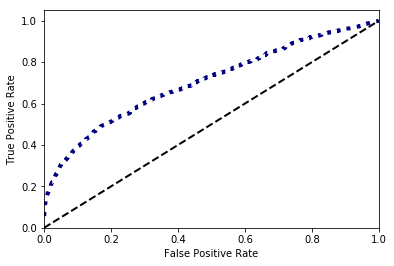

Average AOC 0.7037297775349947


In [38]:
#Based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def compute_mean_auroc(result_dataframe, Y_test, plot_mean_roc=True):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    result_dataframe = result_dataframe.drop(['user_id'], axis=1)
    num_classes = result_dataframe.shape[1]
    result_matrix = result_dataframe.values

    for c in tqdm(range(num_classes)):
        current_Y_test = [int(y == c) for y in Y_test]
        current_Y_score = result_matrix[:, c]
        fpr[c], tpr[c], _ = roc_curve(current_Y_test, current_Y_score)
        roc_auc[c] = auc(fpr[c], tpr[c])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in range(num_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for c in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[c], tpr[c])

    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if plot_mean_roc:
        plt.figure()
        plt.plot(fpr["macro"], tpr["macro"],
                 color='navy', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show(block=False)

    return roc_auc['macro']

auroc = compute_mean_auroc(rm, Y_test)
print('Average AOC', auroc)    